<a href="https://colab.research.google.com/gist/mariolucic/c77672329c6fbe67a566bb6fc6f4d856/variational-autoencoders-on-mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders

This practical session will concentrate on generative modeling with Variational Autoencoders. We will implement the model and train it on MNIST. We will also implement a couple of functions which will allow us to visualize the latent space and image reconstructions based on a trained model. A great tutorial is available [here](https://arxiv.org/abs/1606.05908).

**Note**: The easiest way to use this tutorial is [as a colab notebook](https://colab.sandbox.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb). Enable a free GPU by going to:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**


In [0]:
#@title Imports
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import convolution2d as conv2d
from tensorflow.contrib.slim import max_pool2d as max_pool2d
from tensorflow.contrib.slim import convolution2d_transpose as conv2d_transp
from tensorflow.contrib.slim import layers

import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [0]:
#@title Loading MNIST
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
mnist,num_sample

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f17a2e5e358>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f17a2e5e9e8>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f17a2e5e278>),
 55000)

## Model and loss

As discussed in the lecture, the VAE consists of an encoder and a decoder. In this example, we will set up a simple 3-layer neural network for both. 

1.   The encoder will output the mean and variance parametrizing the approximate posterior.
2.   The decoder will output a value in [0, 1] for each output pixel.

The loss function is the sum of the reconstruction error and the average mismatch between the approximate posterior and the prior measured by KL divergence. Note that in this case both the prior and approximate posterior are multivariate Gaussian distributions for which the KL divergence can be computed in closed-form.

**Basic operations**
1.   **Encoding:** Infering the latent representation of the given input: X -> Z
2.   **Decoding:** Generating the instance corresponding to the given code: Z -> X
3.   **Transmitting:** Encoding followed by decoding of the given input.



In [0]:
class VAE(object):
    def __init__(self, x_dim, z_dim, activation=tf.nn.elu, eps=1e-8):
        self.sess = tf.InteractiveSession()
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, x_dim], name='x')
        self.z_dim = z_dim
        self.build(x_dim, z_dim, activation, eps)

    def __del__(self):
        print("Cleaning up the session.")
        self.sess.close()

    def build(self, input_dim, z_dim, activation, eps):
        X = tf.reshape(self.x, shape=[-1,28,28,1])
        with tf.variable_scope("encoder"):
            net = tf.layers.conv2d(X, filters=32, kernel_size=3, strides=2, padding='same', activation=tf.nn.elu)#14*14
            net = tf.layers.max_pooling2d(net, pool_size=2,strides=2) #7*7
            net = tf.layers.conv2d(net, filters=32, kernel_size=3,strides=2, padding='same', activation=tf.nn.elu)#4*4
            net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)#2*2
            net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, padding='same', activation=tf.nn.elu)#1*1
            net = tf.contrib.layers.flatten(net)
            z_mu = tf.layers.dense(net, units=z_dim)
            z_log_sigma_sq = tf.layers.dense(net, units=z_dim)  
            
            
        with tf.variable_scope("latent_space"):
            std_gauss = tf.random_normal(
            shape=tf.shape(z_log_sigma_sq), mean=0, stddev=1, dtype=tf.float32)
            self.z = z_mu + tf.sqrt(tf.exp(z_log_sigma_sq)) * std_gauss
        
        
        with tf.variable_scope("decoder"): #change the fc to (transpose-)convolution
            net = tf.layers.dense(self.z, units=49, activation=tf.nn.relu)
            net = tf.reshape(net, shape=[-1,7,7,1])
            net = tf.layers.conv2d_transpose(net, filters=16, kernel_size=3, strides=2, padding='same', activation=tf.nn.elu)
            net = tf.layers.conv2d_transpose(net, filters=32, kernel_size=3, strides=1, padding='same', activation=tf.nn.elu)
            net = tf.layers.conv2d_transpose(net, filters=32, kernel_size=3, strides=1, padding='same', activation=tf.nn.elu)
            net = tf.contrib.layers.flatten(net)
            self.x_hat = tf.layers.dense(net, units=28*28, activation=tf.nn.sigmoid)
                 

        with tf.variable_scope("loss"):
            reconstruction_loss = tf.reduce_mean(
            -tf.reduce_sum(
              self.x * tf.log(self.x_hat + eps) + 
              (1 - self.x) * tf.log(1 - self.x_hat + eps), axis=1))

            prior_mismatch_loss = tf.reduce_mean(-0.5 * tf.reduce_sum(
            1 + z_log_sigma_sq - tf.square(z_mu) - tf.exp(z_log_sigma_sq), axis=1))     
            self.loss = reconstruction_loss + prior_mismatch_loss  

                        
    def encode(self, x):
        return self.sess.run(self.z, feed_dict={self.x: x})
    
    def decode(self, z):
        return self.sess.run(self.x_hat, feed_dict={self.z: z})

    def transmit(self, x):
        return self.sess.run(self.x_hat, feed_dict={self.x: x})

  

## Training

We will minimize the VAE loss using the [Adam optimizer](https://arxiv.org/abs/1412.6980). We will provide the learning rate, batch size and the total number of batches to process during optimization. Note that this loss function is non-convex in the parameters of the encoder and decoder. Hence,  when using stochastic minibatch optimization, there are no guarantees on the quality of the solution nor on the convergence. 



In [0]:
def train(vae, learning_rate=1e-3, batch_size=256, n_batches=100):
    with tf.variable_scope("optimizer", reuse=tf.AUTO_REUSE):
        train_op = tf.train.AdamOptimizer(learning_rate).minimize(vae.loss)
        vae.sess.run(tf.global_variables_initializer())
    for batch_idx in range(n_batches):
        batch = mnist.train.next_batch(batch_size)[0]
        current_loss, _ = vae.sess.run([vae.loss, train_op], feed_dict={vae.x: batch})
        if batch_idx % int(n_batches / 10) == 0:
            print("[Batch [%05d] -> loss[%.2f]" % (batch_idx, current_loss))

In [0]:
vae = VAE(x_dim=28*28, z_dim=32)
train(vae, n_batches=32000)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use tf.cast instead.
[Batch [00000] -> loss[545.64]
[Batch [03200] -> loss[112.31]
[Batch [06400] -> loss[104.02]
[Batch [09600] -> loss[102.36]
[Batch [12800] -> loss[104.31]
[Batch [16000] -> loss[100.97]
[Batch [19200] -> loss[101.69]
[Batch [22400] -> loss[97.84]
[Batch [25600] -> loss[99.50]
[Batch [28800] -> loss[95.19]


## Reconstructions and random samples
We will pick a batch of images from MNIST and transmit them through the trained VAE. For each input image we will show the resulting reconstruction.

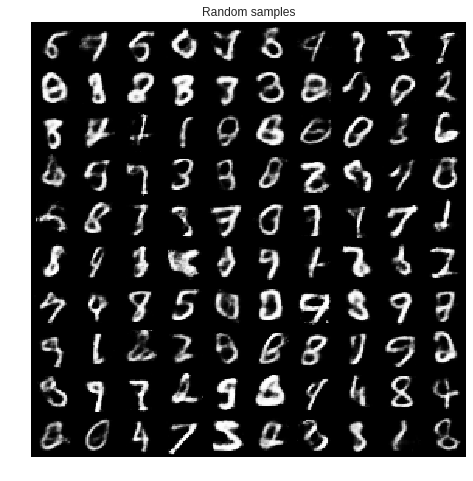

In [0]:
def plot(fig_height, fig_width, canvas, title):
    plt.figure(figsize=(fig_height, fig_width))
    plt.imshow(canvas, cmap='gray')
    plt.axis('off')
    plt.title(title)

def visualize_random_samples(model, batch_size=1024):
    
    n = int(np.sqrt(batch_size))
    h = w = int(np.sqrt(model.x.shape.as_list()[1]))
    z = np.random.normal(size=[batch_size, model.z_dim])
    x_generated = model.decode(z).reshape([n, n, h, w])
    canvas = np.zeros((h * n, w * n))
    for i in range(n):
        for j in range(n):
            canvas[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i][j]
    plot(8, 8, canvas, "Random samples")

visualize_random_samples(vae, 100)

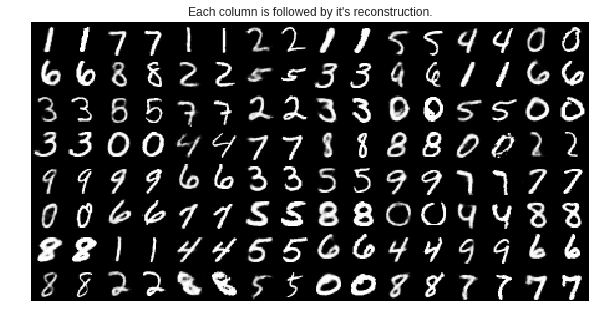

In [0]:
def visualize_reconstructions(model, mnist, batch_size=64):
    n = int(np.sqrt(batch_size))
    h = w = int(np.sqrt(model.x.shape.as_list()[1]))
    batch = mnist.test.next_batch(batch_size)[0]
    x_hat = model.transmit(batch)
    canvas = np.zeros((h * n, w * n * 2))
    for i in range(n):        
        for j in range(n):
            canvas[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = np.concatenate(
          (x_hat[i*n+j, :].reshape(h, w), batch[i*n+j, :].reshape(h, w)), axis=1)
    plot(10, 20, canvas, "Each column is followed by it's reconstruction.")

visualize_reconstructions(vae, mnist, batch_size=64)

## 2D latent space for MNIST

We will now train a VAE which maps each NNIST image (d=28*28=784) into 2 dimensions. Then, we will visualize this 2D space. Then, we will show the decoded samples for all codes in [-1, 1] x [-1, 1].

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Batch [00000] -> loss[543.38]
[Batch [03200] -> loss[157.91]
[Batch [06400] -> loss[152.04]
[Batch [09600] -> loss[146.75]
[Batch [12800] -> loss[149.49]
[Batch [16000] -> loss[149.22]
[Batch [19200] -> loss[142.13]
[Batch [22400] -> loss[151.38]
[Batch [25600] -> loss[146.93]
[Batch [28800] -> loss[147.53]


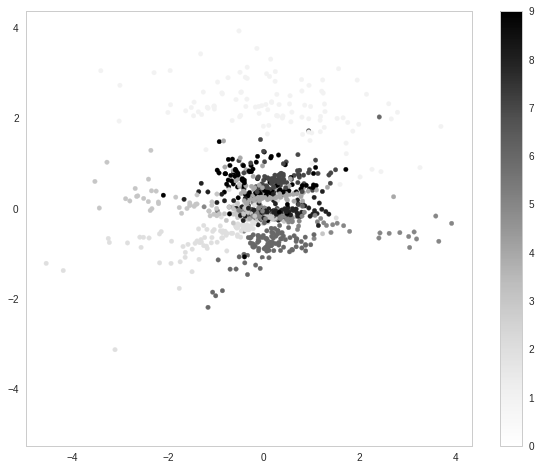

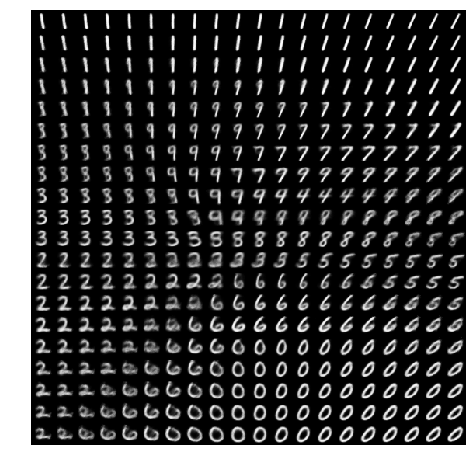

In [0]:
def visualize_latent_2d(model, batch_size=1024):
    x, y = mnist.test.next_batch(batch_size)
    z = model.encode(x)
    h = w = int(np.sqrt(model.x.shape.as_list()[1]))

    plt.figure(figsize=(10, 8))
    plt.scatter(z[:, 0], z[:, 1], c=np.argmax(y, 1), s=20)
    plt.colorbar()
    plt.grid()

    n = 20
    x = y = np.linspace(-2, 2, n)
    canvas = np.empty((h*n, w*n))
    for i, yi in enumerate(x):
        for j, xi in enumerate(y):
            z = np.array([[xi, yi]] * 64)
            x_hat = model.decode(z)
            canvas[(n-i-1)*h:(n-i)*h, j*w:(j+1)*w] = x_hat[0].reshape(h, w)
    plt.figure(figsize=(8, 8))        
    plt.imshow(canvas, cmap="gray")
    plt.axis('off')

tf.reset_default_graph()
vae_2d = VAE(x_dim=28*28, z_dim=2)
train(vae_2d, n_batches=32000)

visualize_latent_2d(vae_2d)    